#### Detect model from Yu, et al
Implementation of the detection model from the Yu, et al [paper](https://drive.google.com/file/d/1nYl4w41CAcj8XwTEdVwcD5lVheUFIHVy/view?usp=sharing)

Data was resized to 224x224 and median filtered 7x7. None type was subsampled to keep only 30,000 random samples.

Refinement on first run. Still tries to follow the paper as closely as possible, but some changes from the first run:
- Added last fully connected layer (FC3) that was accidentally omitted in the first run.
- Saved both model and predictions.

In [4]:
!gsutil cp gs://wafdef/data/resized224/* ../../../data/resized224/

Copying gs://wafdef/data/resized224/WM-clean-id224-dev.zip...
Copying gs://wafdef/data/resized224/WM-clean-id224-test.zip...                  
Copying gs://wafdef/data/resized224/WM-clean-id224-train-clsaug.zip...          
Copying gs://wafdef/data/resized224/WM-clean-id224-train-detund.zip...          
| [4 files][  1.0 GiB/  1.0 GiB]   72.9 MiB/s                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://wafdef/data/resized224/WM-clean-id224-train.zip...
Copying gs://wafdef/data/resized224/WM-clean-id224filter7-dev.zip...            
Copying gs://wafdef/data/resized224/WM-clean-id224filter7-test.zip...           
Copying gs://wafdef/data/resized224/WM-clean-id224filter7-train-clsaug.zip...   
Copying gs://wafdef/data/resized224/WM-clean-id224filte

In [1]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, optimizers

import os
import numpy as np
import pandas as pd
import pickle5 as pickle

import helpers as helper
import seaborn as sns
from sklearn.metrics import confusion_matrix

import time

In [2]:
# specify variables for model
path = '../../../data/resized224'
filename = 'WM-clean-id224filter7'
option = '-detund' # -clsaug, -detund
map_column = 'filterMap7'
label_column = 'detectLabels'
filetype = 'zip' # zip, pkl

model_id = 'yudetect'
result_path = '../results'
note = '-firstrun2' # -optional

In [7]:
# load train, dev, and test sets
start = time.time()

if filetype == 'pkl':
    # open pkl files
    with open(f'{path}/{filename}-train{option}.pkl', "rb") as fh:
        train = pickle.load(fh)
    with open(f'{path}/{filename}-dev.pkl', "rb") as fh:
        dev = pickle.load(fh)
    with open(f'{path}/{filename}-test.pkl', "rb") as fh:
        test = pickle.load(fh)

elif filetype == 'zip':
    train = helper.load(f'{path}/{filename}-train{option}.zip')
    dev = helper.load(f'{path}/{filename}-dev.zip')
    test = helper.load(f'{path}/{filename}-test.zip')

print("Wall time: {} seconds".format(time.time() - start))
print(f"Train: {len(train)}")
print(f"Dev: {len(dev)}")
print(f"Test: {len(test)}")

Wall time: 81.89132523536682 seconds
Train: 47863
Dev: 25942
Test: 25943


#### Quick EDA

In [8]:
# baseline accuracy of test set
nones = len(test[test.failureType == 'none'])
total = len(test)
print(f"Baseline accuracy: {nones/total*100:.2f}%")

Baseline accuracy: 85.24%


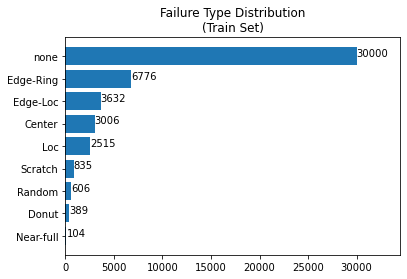

In [9]:
# train failure type distribution
helper.defect_distribution(train, note='Train Set')

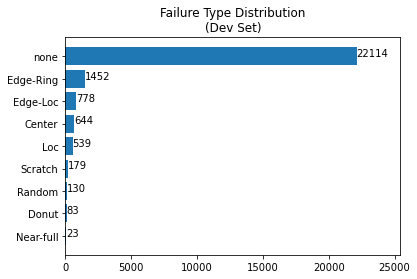

In [10]:
# dev failure type distribution
helper.defect_distribution(dev, note='Dev Set')

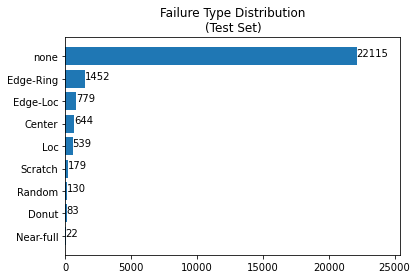

In [11]:
# test failure type distribution
helper.defect_distribution(test, note='Test Set')

#### Data set-up

In [12]:
# prepare inputs
start = time.time()

x_train = np.stack(train[map_column])
x_val = np.stack(dev[map_column])
x_test = np.stack(test[map_column])

print("Wall time: {} seconds".format(time.time() - start))

# sanity check
# expected: (#rows, xdim, ydim)
x_train.shape

MemoryError: Unable to allocate 17.9 GiB for an array with shape (47863, 224, 224) and data type float64

In [ ]:
# expand tensor and create dummy dimension at axis 3
# images in greyscale, so no channel dimension
start = time.time()

x_train = tf.expand_dims(x_train, axis=3, name=None)
x_val = tf.expand_dims(x_val, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)

print("Wall time: {} seconds".format(time.time() - start))

# sanity check
# expected: TensorShape([#rows, xdim, ydim, 1])
x_train.shape

In [ ]:
# prepare labels for supervised learning
# note: make sure labels are integers if using sparse categorical cross entropy
y_train = np.asarray(train[label_column]).astype('int64')
y_val = np.asarray(dev[label_column]).astype('int64')
y_test = np.asarray(test[label_column]).astype('int64')

# sanity check
# expected: type = int
type(y_train[0])

#### Model

In [ ]:
# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=x_train.shape[1:]))
model.add(layers.MaxPooling2D(3))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(3))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(3))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='sigmoid'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

In [ ]:
# set model optimizer and metrics
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [ ]:
# run model
history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val))

In [ ]:
# visualize accuracy and loss history
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

#### Model results

In [ ]:
# compute model results on test set
start = time.time()
results = model.evaluate(x_test, y_test)
print("Wall time: {} seconds".format(time.time() - start))
print()
print(results)

In [ ]:
# generate predictions for model analysis
start = time.time()
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print("Wall time: {} seconds".format(time.time() - start))

In [ ]:
# save results, history, and predictions
with open(f'{result_path}/{model_id}-{filename}{option}{note}.pkl', "wb") as f:
    pickle.dump(y_pred, f)

In [ ]:
# save model
model.save(f'{result_path}/{model_id}-{filename}{option}{note}')

In [ ]:
# plot confusion matrix
helper.plot_confusion_matrix(y_test, y_pred, mode='detect', normalize=True)

In [ ]:
# plot confusion matrix counts
helper.plot_confusion_matrix(y_test, y_pred, mode='detect', normalize=False)